In [ ]:
# default_exp modeling.core


In [ ]:
# all_slow


In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.core

> This module contains core custom models, loss functions, and a default layer group splitter for use in applying discriminiative learning rates to your Hugging Face models trained via fastai

In [ ]:
# export
import os, inspect
from typing import Any, Callable, Dict, List, Optional, Union, Type

from fastcore.all import *
from fastai.callback.all import *
from fastai.data.block import DataBlock, ColReader, CategoryBlock, MultiCategoryBlock, ColSplitter, RandomSplitter
from fastai.data.core import DataLoader, DataLoaders, TfmdDL
from fastai.imports import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import accuracy, F1Score, accuracy_multi, F1ScoreMulti
from fastai.torch_core import *
from fastai.torch_imports import *
from fastprogress.fastprogress import progress_bar, master_bar
from transformers import AutoModelForSequenceClassification, logging, PretrainedConfig, PreTrainedTokenizerBase, PreTrainedModel

from blurr.utils import BLURR, set_seed
from blurr.data.core import HF_TextBlock, HF_BaseInput, first_blurr_tfm

logging.set_verbosity_error()


In [ ]:
# hide_input
import pdb

from datasets import concatenate_datasets, load_dataset
from fastai.data.external import untar_data, URLs
from fastcore.test import *
from nbverbose.showdoc import show_doc

from blurr.utils import print_versions
from blurr.data.core import BlurrDataLoader

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")


What we're running with at the time this documentation was generated:
torch: 1.10.1+cu111
fastai: 2.5.3
transformers: 4.15.0


In [ ]:
# hide
# cuda
torch.cuda.set_device(1)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")


Using GPU #1: GeForce GTX 1080 Ti


## Base splitter, model wrapper, and model callback

In [ ]:
# export
def hf_splitter(m: Module):
    """Splits the Hugging Face model based on various model architecture conventions"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    top_module_name, top_module = root_modules[0]

    groups = L([m for m_name, m in list(top_module.named_children())])
    groups += L([m for m_name, m in root_modules[1:]])

    return groups.map(params).filter(lambda el: len(el) > 0)


In [ ]:
show_doc(hf_splitter)


<h4 id="hf_splitter" class="doc_header"><code>hf_splitter</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>hf_splitter</code>(**`m`**:`Module`)

Splits the Hugging Face model based on various model architecture conventions

**Parameters:**


 - **`m`** : *`<class 'fastai.torch_core.Module'>`*


In [ ]:
# export
class HF_BaseModelWrapper(Module):
    def __init__(
        self,
        # Your Hugging Face model
        hf_model: PreTrainedModel,
        # If True, hidden_states will be returned and accessed from Learner
        output_hidden_states: bool = False,
        # If True, attentions will be returned and accessed from Learner
        output_attentions: bool = False,
        # Any additional keyword arguments you want passed into your models forward method
        hf_model_kwargs={},
    ):
        super().__init__()

        store_attr(self=self, names="output_hidden_states, output_attentions, hf_model_kwargs")
        self.hf_model = hf_model.cuda() if torch.cuda.is_available() else hf_model

        self.hf_model_fwd_args = list(inspect.signature(self.hf_model.forward).parameters.keys())

    def forward(self, x):
        for k in list(x):
            if k not in self.hf_model_fwd_args:
                del x[k]

        return self.hf_model(
            **x,
            output_hidden_states=self.output_hidden_states,
            output_attentions=self.output_attentions,
            return_dict=True,
            **self.hf_model_kwargs
        )


Note that `HF_BaseModelWrapper` includes some nifty code for just passing in the things your model needs, as not all transformer architectures require/use the same information.

In [ ]:
# export
class HF_PreCalculatedLoss:
    def __call__(self, inp, targ, **kwargs):
        return tensor(0.0)

    def decodes(self, x):
        return x.argmax(dim=-1)

    def activation(self, x):
        return F.softmax(x, dim=-1)


If you want to let your Hugging Face model calculate the loss for you, make sure you include the `labels` argument in your inputs and use `HF_PreCalculatedLoss` as your loss function. Even though we don't really need a loss function per se, we have to provide a custom loss class/function for fastai to function properly (e.g. one with a `decodes` and `activation` methods).  Why?  Because these methods will get called in methods like `show_results` to get the actual predictions.

**Note**: The Hugging Face models ***will always*** calculate the loss for you ***if*** you pass a `labels` dictionary along with your other inputs (so only include it if that is what you intend to happen)

In [ ]:
# export
class HF_BaseModelCallback(Callback):
    def before_batch(self):
        self.hf_loss = None

    def after_pred(self):
        model_outputs = self.pred
        self.learn.blurr_model_outputs = {}

        for k, v in model_outputs.items():
            # if the "labels" are included, we are training with target labels in which case the loss is returned
            if k == "loss" and isinstance(self.learn.loss_func, HF_PreCalculatedLoss):
                self.hf_loss = to_float(v)
            # the logits represent the prediction
            elif k == "logits":
                self.learn.pred = v
            # add any other things included in model_outputs as blurr_{model_output_key}
            else:
                self.learn.blurr_model_outputs[k] = v

    def after_loss(self):
        # if we already have the loss from the model, update the Learner's loss to be it
        if self.hf_loss is not None:
            self.learn.loss_grad = self.hf_loss
            self.learn.loss = self.learn.loss_grad.clone()


We use a `Callback` for handling what is returned from the Hugging Face model. The return type is (`ModelOutput`)[https://huggingface.co/transformers/main_classes/output.html#transformers.file_utils.ModelOutput] which makes it easy to return all the goodies we asked for.

Note that your `Learner`'s loss will be set for you only if the Hugging Face model returns one *and* you are using the `HF_PreCalculatedLoss` loss function.  

Also note that anything else you asked the model to return (for example, last hidden state, etc..) will be available for you via the `blurr_model_outputs` property attached to your `Learner`. For example, assuming you are using BERT for a classification task ... if you have told your `HF_BaseModelWrapper` instance to return attentions, you'd be able to access them via `learn.blurr_model_outputs['attentions']`.

## Sequence classification

Below demonstrates how to setup your `blurr` pipeline for a sequence classification task (e.g., a model that requires a single text input) using the mid, high, and low-level API

### Using the mid-level API

In [ ]:
raw_datasets = load_dataset("imdb", split=['train', 'test'])
raw_datasets[0] = raw_datasets[0].add_column('is_valid', [False] * len(raw_datasets[0]))
raw_datasets[1] = raw_datasets[1].add_column('is_valid', [True] * len(raw_datasets[1]))

final_ds = concatenate_datasets([raw_datasets[0].shuffle().select(range(1000)), raw_datasets[1].shuffle().select(range(200))])
imdb_df = pd.DataFrame(final_ds)
imdb_df.head()

Reusing dataset imdb (/home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/4ea52f2e58a08dbc12c2bd52d0d92b30b88c00230b4522801b3636782f625c5b)


,label,text,is_valid
0,1,"While the original 1932 version, with Preston Foster, was good, there's no remake more worthy than this 1959 one, or more impossible to find anywhere, just as I strongly suspect Mickey Rooney to have had something to do with that. Never could a mere performance have ever been so masterfully brilliant, or a script more thought-provoking, as well as an improvement upon the original. Many years after the last of my several viewings of this film, in 1970, I read an article in which Mickey Rooney was recounting a visit he'd made to death row, and which had apparently very drastically eliminated...",False
1,1,"Ironically the most talked-about American film in the 2008 New York Film Festival is 98% in Spanish. The extra-long film's controversy began at the Cannes Festival. There were love-hate notices, and considerable doubts about commercial prospects. As consolation the star, Benicio Del Toro, got the Best Actor award there. I'm talking about Steven Soderbergh's 'Che,' of course. That's the name it's going by in this version, shown in New York as at Cannes in two 2-hour-plus segments without opening title or end credits. 'Che' is certainly appropriate since Ernesto ""Che"" Guevara is in almost ev...",False
2,0,"Bingo is the game, bullshit is the name. Rarely has the screen been smeared with such a blown-up hodgepodge of half-baked conspiracy theories, puritan prudery, and new-age gibberish. The bulk of the story is set at Viciente, a Cristian resort in the Peruvian jungle. Think Tolkien's Rivendell meets Star Trek's Planet Baku, inhabited by dimwitted followers of a not-so-mysterious, but surprisingly narrow-minded cult of love and peace. Thanks to gruesome acting and tacky production design (the rainbow-colored visualization of the mysterious all-healing ""energy"" is particularly hideous), ""The C...",False
3,1,"There are so many reasons as to why I rate the sopranos so highly, one of its biggest triumphs being the cast and character building. Each character unfolds more and more each series. Also each series has an array of different 'small time characters' as well as the main. A good example of a character (who was only in three episodes) who you can feel for is David the compulsive gambler played brilliantly by Robert Patrick. Every little detail builds the perfect TV series. The show revolves round mob boss Tony Soprano (James Gandolfini) who attempts to balance his life of crime with his role...",False
4,0,"I thought watching employment videos on corporate compliance was tedious. This movie went nowhere fast. What could have been a somewhat cheesy half hour twilight zone episode turned into a seemingly endless waste of film on people parking their cars, a picture of some dude's swimming pool (he really needs to answer his phone by the way) a dot matrix printer doing its job, and Heuy and Louey sitting in a yellow lighted control room repeating ""T minus 10 and counting"" as if something exciting is going to happen. It doesn't so don't get your hopes up. The best thing about this movie is to see...",False


In [ ]:
labels = raw_datasets[0].features['label'].names
labels


['neg', 'pos']

In [ ]:
# hide_output
model_cls = AutoModelForSequenceClassification

pretrained_model_name = "distilroberta-base"  # "distilbert-base-uncased" "bert-base-uncased"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)


In [ ]:
# single input
set_seed()
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model, before_batch_kwargs={"labels": labels}), CategoryBlock)
dblock = DataBlock(blocks=blocks, get_x=ColReader("text"), get_y=ColReader("label"), splitter=RandomSplitter(seed=42))


In [ ]:
# hide
# dblock.summary(imdb_df)


In [ ]:
dls = dblock.dataloaders(imdb_df, bs=4)


In [ ]:
# dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)


#### Training

We'll also add in custom summary methods for blurr learners/models that work with dictionary inputs

In [ ]:
set_seed()

model = HF_BaseModelWrapper(hf_model)
learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[HF_BaseModelCallback],
    splitter=hf_splitter,
)

learn.freeze()


`.to_fp16()` requires a GPU so had to remove for tests to run on github.  Let's check that we can get predictions.

In [ ]:
# hide_output
# learn.summary()


In [ ]:
# print(len(learn.opt.param_groups))


SuggestedLRs(minimum=3.981071640737355e-05, steep=0.0003311311302240938, valley=6.30957365501672e-05, slide=0.001737800776027143)

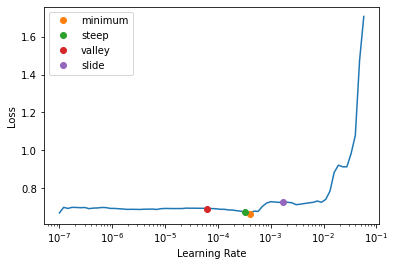

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])


In [ ]:
set_seed()
learn.fit_one_cycle(1, lr_max=1e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.365132,0.285754,0.879167,00:19


epoch	train_loss	valid_loss	accuracy	time
0	0.324516	0.294210	0.885000	00:11

#### Showing results

And here we create a @typedispatched implementation of `Learner.show_results`.

In [ ]:
# export
@typedispatch
def show_results(
    # This typedispatched `show_results` will be called for `HF_BaseInput` typed inputs
    x: HF_BaseInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # The model's predictions
    outs,
    # Your `Learner`. This is required so as to get at the Hugging Face objects for decoding them into
    # something understandable
    learner,
    # Your `show_results` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_results`
    **kwargs,
):
    # grab our tokenizer
    tfm = first_blurr_tfm(learner.dls)
    hf_tokenizer = tfm.hf_tokenizer

    # if we've included our labels list, we'll use it to look up the value of our target(s)
    trg_labels = tfm.kwargs['labels'] if ('labels' in tfm.kwargs) else None

    res = L()
    n_inp = learner.dls.n_inp

    for idx, (input_ids, label, pred, sample) in enumerate(zip(x, y, outs, samples)):
        if idx >= max_n:
            break

        # add in the input text
        rets = [hf_tokenizer.decode(input_ids, skip_special_tokens=True)[:trunc_at]]
        # add in the targets
        for item in sample[n_inp:]:
            if not torch.is_tensor(item):
                trg = trg_labels[int(item)] if trg_labels else item
            elif is_listy(item.tolist()):
                trg = [trg_labels[idx] for idx, val in enumerate(label.numpy().tolist()) if (val == 1)] if (trg_labels) else label.item()
            else:
                trg = trg_labels[label.item()] if (trg_labels) else label.item()

            rets.append(trg)
        # add in the predictions
        for item in pred:
            if not torch.is_tensor(item):
                p = trg_labels[int(item)] if trg_labels else item
            elif is_listy(item.tolist()):
                p = [trg_labels[idx] for idx, val in enumerate(item.numpy().tolist()) if (val == 1)] if (trg_labels) else item.item()
            else:
                p = trg_labels[item.item()] if (trg_labels) else item.item()

            rets.append(p)

        res.append(tuplify(rets))

    cols = ["text"] + ["target" if (i == 0) else f"target_{i}" for i in range(len(res[0]) - n_inp * 2)]
    cols += ["prediction" if (i == 0) else f"prediction_{i}" for i in range(len(res[0]) - n_inp * 2)]
    display_df(pd.DataFrame(res, columns=cols)[:max_n])
    return ctxs


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)


,text,target,prediction
0,"The title is onomatopoeic, the sound of a streetcar clacking on the rails. It is metaphoric for all that the people who live in the dump cannot have. The misery of those people is illustrated by the passing streetcar which represents the relatively unobtainable rich life of the middle class. The pathos of the little boy and his beloved yet sadly insane father is most touching. This was Kurosawa's first film in colour and he uses beautifully shocking hues, colours seen only in dreams. The movie",pos,pos
1,"Michael Cacoyannis has had a relatively long career but has surprisingly few credits to his name, including some real duds such as the unfunny cold war satire The Day the Fish Came Out. Iphigenia, however, is a highlight. Adapted by Cacoyannis from the play by Euripides, it's a superior rendering of the classic tragedy and recently made its first television appearance in many years in the United States courtesy the Flix Channel. The film is shot on an epic scale but is decidedly not a 'big' fil",pos,pos


In [ ]:
learn.unfreeze()


In [ ]:
set_seed()
learn.fit_one_cycle(2, lr_max=slice(1e-7, 1e-4))


epoch,train_loss,valid_loss,accuracy,time
0,0.270743,0.259033,0.887500,00:29
1,0.194705,0.255097,0.883333,00:28


epoch	train_loss	valid_loss	accuracy	time
0	0.263290	0.272322	0.895000	00:18
1	0.218568	0.263317	0.910000	00:18

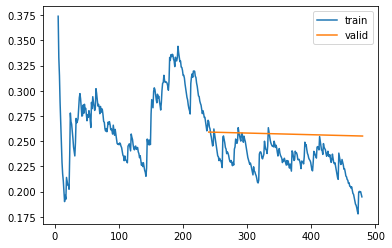

In [ ]:
learn.recorder.plot_loss()


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)


,text,target,prediction
0,"The title is onomatopoeic, the sound of a streetcar clacking on the rails. It is metaphoric for all that the people who live in the dump cannot have. The misery of those people is illustrated by the passing streetcar which represents the relatively unobtainable rich life of the middle class. The pathos of the little boy and his beloved yet sadly insane father is most touching. This was Kurosawa's first film in colour and he uses beautifully shocking hues, colours seen only in dreams. The movie",pos,pos
1,"Michael Cacoyannis has had a relatively long career but has surprisingly few credits to his name, including some real duds such as the unfunny cold war satire The Day the Fish Came Out. Iphigenia, however, is a highlight. Adapted by Cacoyannis from the play by Euripides, it's a superior rendering of the classic tragedy and recently made its first television appearance in many years in the United States courtesy the Flix Channel. The film is shot on an epic scale but is decidedly not a 'big' fil",pos,pos


In [ ]:
# export
@patch
def blurr_predict(self: Learner, items, rm_type_tfms=None):
    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)
    trg_labels = tfm.kwargs['labels'] if ('labels' in tfm.kwargs) else None

    is_split_str = tfm.is_split_into_words and isinstance(items[0], str)
    is_df = isinstance(items, pd.DataFrame)

    if not is_df and (is_split_str or not is_listy(items)):
        items = [items]
    dl = self.dls.test_dl(items, rm_type_tfms=rm_type_tfms, num_workers=0)

    with self.no_bar():
        probs, _, decoded_preds = self.get_preds(dl=dl, with_input=False, with_decoded=True)

    trg_tfms = self.dls.tfms[self.dls.n_inp:]

    outs = []
    probs, decoded_preds = L(probs), L(decoded_preds)
    for i in range(len(items)):
        item_probs = probs.itemgot(i)
        item_dec_preds = decoded_preds.itemgot(i)
        item_dec_labels = tuplify([tfm.decode(item_dec_preds[tfm_idx]) for tfm_idx, tfm in enumerate(trg_tfms)])
        if trg_labels:
            item_dec_labels = [trg_labels[int(lbl)] for item in item_dec_labels for lbl in item]

        outs.append((item_dec_labels, item_dec_preds, item_probs))

    return outs


In [ ]:
show_doc(Learner.blurr_predict)


<h4 id="Learner.blurr_predict" class="doc_header"><code>Learner.blurr_predict</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.blurr_predict</code>(**`items`**, **`rm_type_tfms`**=*`None`*)



**Parameters:**


 - **`items`** : *`<class 'inspect._empty'>`*

 - **`rm_type_tfms`** : *`<class 'NoneType'>`*, *optional*


We need to replace fastai's `Learner.predict` method with the one above which is able to work with inputs that are represented by multiple tensors included in a dictionary.

In [ ]:
learn.blurr_predict("I really liked the movie")



[(['pos'], (#1) [tensor(1)], (#1) [tensor([0.0601, 0.9399])])]

In [ ]:
learn.blurr_predict("Acting was so bad it was almost funny.")

[(['neg'], (#1) [tensor(0)], (#1) [tensor([0.8857, 0.1143])])]

In [ ]:
learn.blurr_predict(["I really liked the movie", "I really hated the movie"])



[(['pos'], (#1) [tensor(1)], (#1) [tensor([0.0601, 0.9399])]),
 (['neg'], (#1) [tensor(0)], (#1) [tensor([0.5126, 0.4874])])]

Though not useful in sequence classification, we will also add a `blurr_generate` method to `Learner` that uses Hugging Face's `PreTrainedModel.generate` for text generation tasks.  

For the full list of arguments you can pass in see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate). You can also check out their ["How To Generate"](https://github.com/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb) notebook for more information about how it all works.

In [ ]:
# export
@patch
def blurr_generate(self: Learner, inp, **kwargs):
    """Uses the built-in `generate` method to generate the text 
    (see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
    for a list of arguments you can pass in)
    """
    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)

    # grab the Hugging Face tokenizer from the learner's dls.tfms
    hf_config = tfm.hf_config
    hf_tokenizer = tfm.hf_tokenizer
    tok_kwargs = tfm.tok_kwargs

    # grab the text generation kwargs
    text_gen_kwargs = tfm.text_gen_kwargs if (len(kwargs) == 0) else kwargs

    if isinstance(inp, str):
        input_ids = hf_tokenizer.encode(inp, padding=True, truncation=True, return_tensors="pt", **tok_kwargs)
    else:
        # note (10/30/2020): as of pytorch 1.7, this has to be a plain ol tensor (not a subclass of TensorBase)
        input_ids = inp.as_subclass(Tensor)

    input_ids = input_ids.to(self.model.hf_model.device)

    gen_texts = self.model.hf_model.generate(input_ids, **text_gen_kwargs)
    outputs = [hf_tokenizer.decode(txt, skip_special_tokens=True, clean_up_tokenization_spaces=False) for txt in gen_texts]

    if tfm.hf_arch == "pegasus":
        outputs = [o.replace("<n>", " ") for o in outputs]

    return outputs


In [ ]:
show_doc(Learner.blurr_generate)


<h4 id="Learner.blurr_generate" class="doc_header"><code>Learner.blurr_generate</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.blurr_generate</code>(**`inp`**, **\*\*`kwargs`**)

Uses the built-in `generate` method to generate the text 
(see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
for a list of arguments you can pass in)

**Parameters:**


 - **`inp`** : *`<class 'inspect._empty'>`*

 - **`kwargs`** : *`<class 'inspect._empty'>`*


#### Inference

In [ ]:
export_fname = "seq_class_learn_export"


#### Using fast.ai `Learner.export` and `load_learner`

In [ ]:
learn.export(fname=f"{export_fname}.pkl")


In [ ]:
inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_predict("This movie should not be seen by anyone!!!!")


[(['neg'], (#1) [tensor(0)], (#1) [tensor([0.9423, 0.0577])])]

In [ ]:
# hide
try:
    del learn
    del inf_learn
    torch.cuda.empty_cache()
except:
    pass


### Using the high-level API

#### Blearner

Instead of constructing our low-level `Learner`, we can use the `Blearner` class which provides sensible defaults for training

In [ ]:
# hide_output
model_cls = AutoModelForSequenceClassification

pretrained_model_name = "distilroberta-base"  # "distilbert-base-uncased" "bert-base-uncased"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)

dls = dblock.dataloaders(imdb_df, bs=4)


In [ ]:
# export
@delegates(Learner.__init__)
class Blearner(Learner):
    def __init__(
        self,
        # Your fast.ai DataLoaders
        dls: DataLoaders,
        # Your pretrained Hugging Face transformer
        hf_model: PreTrainedModel,
        # Your `HF_BaseModelCallback`
        base_model_cb: HF_BaseModelCallback = HF_BaseModelCallback,
        # Any kwargs you want to pass to your `BLearner`
        **kwargs
    ):
        model = kwargs.get("model", HF_BaseModelWrapper(hf_model))
        loss_func = kwargs.pop("loss_func", dls.loss_func if hasattr(dls, "loss_func") else None)
        splitter = kwargs.pop("splitter", hf_splitter)

        super().__init__(dls, model=model, loss_func=loss_func, splitter=splitter, **kwargs)

        self.add_cb(base_model_cb)
        self.freeze()


In [ ]:
learn = Blearner(dls, hf_model, metrics=[accuracy])


In [ ]:
learn.fit_one_cycle(1, lr_max=1e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.328734,0.285076,0.887500,00:19


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)


,text,target,prediction
0,"I love this movie, Jouvet, Arletty, Blier, Carné... almost everything has already been said about the movie, but there is one detail I'd like to shed some light onto: no footage of the real, still standing, Hôtel du Nord (is it still? I heard it was to be demolished...) has been used for the movie - the whole scene has been rebuilt on set, the main reason being that they could not stop the traffic on the St Martin canal for several weeks.",pos,neg
1,"The eight Jean Rollin film I have watched is also possibly the weirdest; the intriguing plot (such as it is) seems initially to be too flimsy to sustain even its trim 84 minutes but it somehow contrives to get inordinately muddled as it goes along! A would-be female vampire (scantily-clad, as promised by the title) is held in captivity inside a remote château and emerges only to 'feast' on the blood of willing victims (who are apparently members of a suicide club) As if unsure where all of this",neg,pos


In [ ]:
learn.blurr_predict("This was a really good movie")


[(['pos'], (#1) [tensor(1)], (#1) [tensor([0.1776, 0.8224])])]

In [ ]:
learn.export(fname=f"{export_fname}.pkl")
inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_predict("This movie should not be seen by anyone!!!!")


[(['neg'], (#1) [tensor(0)], (#1) [tensor([0.8941, 0.1059])])]

#### BlearnerForSequenceClassification

We also introduce a task specific `Blearner` that get you your DataBlock, DataLoaders, and BLearner in one line of code!

In [ ]:
# hide
try:
    del learn
    del inf_learn
    torch.cuda.empty_cache()
except:
    pass


In [ ]:
# export
@delegates(Blearner.__init__)
class BlearnerForSequenceClassification(Blearner):
    def __init__(self, dls: DataLoaders, hf_model: PreTrainedModel, **kwargs):
        super().__init__(dls, hf_model, **kwargs)

    @classmethod
    def get_model_cls(self):
        return AutoModelForSequenceClassification

    @classmethod
    def _get_x(cls, r, attr):
        return r[attr] if (isinstance(attr, str)) else tuple(r[inp] for inp in attr)

    @classmethod
    def _get_y(cls, r, attr):
        return r[attr] if (isinstance(attr, str)) else [r[inp] for inp in attr]

    @classmethod
    def _create_learner(
        cls,
        # Your raw dataset
        data,
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path: Optional[Union[str, os.PathLike]],
        # A function to perform any preprocessing required for your Dataset
        preprocess_func: Callable = None,
        # The attribute in your dataset that contains your raw text
        text_attr: str = "text",
        # The attribute in your dataset that contains your labels/targets
        label_attr: str = "label",
        # The number of labels/classes your model should predict
        n_labels: int = 2,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter: Callable = RandomSplitter(),
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs={},
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs={},
    ):
        # get our hf objects
        hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(
            pretrained_model_name_or_path, model_cls=cls.get_model_cls(), config_kwargs={"num_labels": n_labels}
        )

        # if we need to preprocess the raw data before creating our DataLoaders
        if preprocess_func:
            data = preprocess_func(data, hf_arch, hf_config, hf_tokenizer, hf_model, text_attr, label_attr)

        # not all architectures include a native pad_token (e.g., gpt2, ctrl, etc...), so we add one here
        if hf_tokenizer.pad_token is None:
            hf_tokenizer.add_special_tokens({"pad_token": "<pad>"})
            hf_config.pad_token_id = hf_tokenizer.get_vocab()["<pad>"]
            hf_model.resize_token_embeddings(len(hf_tokenizer))

        # defin our input/target getters
        if isinstance(data, pd.DataFrame):
            get_x = ColReader(text_attr)
            get_y = ColReader(label_attr)
        else:
            get_x = partial(cls._get_x, attr=text_attr)
            get_y = partial(cls._get_y, attr=label_attr)

        # infer loss function and default metrics
        if is_listy(label_attr):
            trg_block = MultiCategoryBlock(encoded=True, vocab=label_attr)
            learner_kwargs["metrics"] = learner_kwargs.get("metrics", [F1ScoreMulti(), accuracy_multi])
        else:
            trg_block = CategoryBlock
            learner_kwargs["metrics"] = learner_kwargs.get("metrics", [F1Score(), accuracy])

        # build our DataBlock and DataLoaders
        blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), trg_block)
        dblock = DataBlock(blocks=blocks, get_x=get_x, get_y=get_y, splitter=dblock_splitter)

        dls = dblock.dataloaders(data, **dl_kwargs.copy())

        # return BLearner instance
        return cls(dls, hf_model, **learner_kwargs.copy())

    @classmethod
    def from_dataframe(
        cls,
        # Your pandas DataFrame
        df: pd.DataFrame,
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path: Optional[Union[str, os.PathLike]],
        # A function to perform any preprocessing required for your Dataset
        preprocess_func: Callable = None,
        # The attribute in your dataset that contains your raw text
        text_attr: str = "text",
        # The attribute in your dataset that contains your labels/targets
        label_attr: str = "label",
        # The number of labels/classes your model should predict
        n_labels: int = None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter: Callable = ColSplitter(),
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs={},
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs={},
    ):
        # we need to tell transformer how many labels/classes to expect
        if n_labels is None:
            n_labels = len(label_attr) if (is_listy(label_attr)) else len(df[label_attr].unique())

        return cls._create_learner(
            df, pretrained_model_name_or_path, preprocess_func, text_attr, label_attr, n_labels, dblock_splitter, dl_kwargs, learner_kwargs
        )

    @classmethod
    def from_csv(
        cls,
        # The path to your csv file
        csv_file: Union[Path, str],
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path: Optional[Union[str, os.PathLike]],
        # A function to perform any preprocessing required for your Dataset
        preprocess_func: Callable = None,
        # The attribute in your dataset that contains your raw text
        text_attr: str = "text",
        # The attribute in your dataset that contains your labels/targets
        label_attr: str = "label",
        # The number of labels/classes your model should predict
        n_labels: int = None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter: Callable = ColSplitter(),
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs={},
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs={},
    ):
        df = pd.read_csv(csv_file)

        return cls.from_dataframe(
            df,
            pretrained_model_name_or_path=pretrained_model_name_or_path,
            preprocess_func=preprocess_func,
            text_attr=text_attr,
            label_attr=label_attr,
            n_labels=n_labels,
            dblock_splitter=dblock_splitter,
            dl_kwargs=dl_kwargs,
            learner_kwargs=learner_kwargs,
        )

    @classmethod
    def from_dictionaries(
        cls,
        # A list of dictionaries
        ds: List[Dict],
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path: Optional[Union[str, os.PathLike]],
        # A function to perform any preprocessing required for your Dataset
        preprocess_func: Callable = None,
        # The attribute in your dataset that contains your raw text
        text_attr: str = "text",
        # The attribute in your dataset that contains your labels/targets
        label_attr: str = "label",
        # The number of labels/classes your model should predict
        n_labels: int = None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter: Callable = RandomSplitter(),
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs={},
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs={},
    ):
        # we need to tell transformer how many labels/classes to expect
        if n_labels is None:
            n_labels = len(label_attr) if (is_listy(label_attr)) else len(set([item[label_attr] for item in ds]))

        return cls._create_learner(
            ds, pretrained_model_name_or_path, preprocess_func, text_attr, label_attr, n_labels, dblock_splitter, dl_kwargs, learner_kwargs
        )



In [ ]:
learn = BlearnerForSequenceClassification.from_dataframe(
    imdb_df, "distilroberta-base", text_attr="text", label_attr="label", dl_kwargs={"bs": 4}
)


In [ ]:
learn.fit_one_cycle(1, lr_max=1e-3)


epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.383753,0.211999,0.902564,0.905000,00:20


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


,text,target,prediction
0,"Don't be fooled by the plot out-line as it is described on the cover (at least the Swedish version). The story on this seems rather interesting, with speculative hints. Nothing can be further from the truth. This is the absolute most sad movie experience I've ever had... It is plain and right AWFUL and should not be sold or rented to anyone. If you still think the plot seems intriguing, reflect on this: telephones can move, run and kill people as can also any other electric appliance. It can th",0,0
1,"Where to begin.... This hideous excuse for a motion picture makes ""Plan 9 From Outer Space"" look well thought out. The music? It's culled from every single overwrought piece of PD shlock in existence. The focus? Hell, doesn't matter if in one shot there are thirty people standing in the road; the new angle shows a lone Packard with a waitress posing for Argosy Mag shots. Paul Le Mat, Diana Scarwid, Louise Fletcher, Wallace Shawn: fine actors who must have all been starving to death at that poin",0,0


In [ ]:
learn.blurr_predict("This was a really good movie")


[(('1',), (#1) [tensor(1)], (#1) [tensor([0.1197, 0.8803])])]

In [ ]:
learn.export(fname=f"{export_fname}.pkl")
inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_predict("This movie should not be seen by anyone!!!!")


[(('0',), (#1) [tensor(0)], (#1) [tensor([0.9291, 0.0709])])]

### Using the low-level API

Thanks to the `BlurrDataLoader`, there isn't really anything you have to do to use plain ol' PyTorch or fast.ai `Dataset`s and `DataLoaders` with Blurr.  Let's take a look at fine-tuning a model against Glue's MRPC dataset ...

In [ ]:
model_cls = AutoModelForSequenceClassification

pretrained_model_name = "distilroberta-base"  # "distilbert-base-uncased" "bert-base-uncased"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)

In [ ]:
from datasets import load_dataset
from blurr.data.core import preproc_hf_dataset

raw_datasets = load_dataset("glue", "mrpc")


Reusing dataset glue (/home/wgilliam/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [ ]:
def tokenize_function(example):
    return hf_tokenizer(example["sentence1"], example["sentence2"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)


  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
label_names = raw_datasets["train"].features["label"].names

trn_dl = BlurrDataLoader(
    tokenized_datasets["train"],
    hf_arch=hf_arch,
    hf_config=hf_config,
    hf_tokenizer=hf_tokenizer,
    hf_model=hf_model,
    preproccesing_func=preproc_hf_dataset,
    batch_tfm_kwargs={'labels': label_names},
    shuffle=True,
    batch_size=8,
)

val_dl = BlurrDataLoader(
    tokenized_datasets["validation"],
    hf_arch=hf_arch,
    hf_config=hf_config,
    hf_tokenizer=hf_tokenizer,
    hf_model=hf_model,
    preproccesing_func=preproc_hf_dataset,
    batch_tfm_kwargs={'labels': label_names},
    batch_size=16,
)

dls = DataLoaders(trn_dl, val_dl)


And with our fast.ai `DataLoaders` in hand, we can train our model's using the high or low-level Blurr API.  The `BlurrDataLoader` class sets up everything so that we can use our objects just as if we built our `DataLoaders` with the mid-level `DataBlock` API.  This means we get back methods like `one_batch`, `show_batch`, `show_results`, etc... with all levels of Blurr's API.

In [ ]:
learn = BlearnerForSequenceClassification(dls, hf_model, loss_func=HF_PreCalculatedLoss())


SuggestedLRs(valley=5.248074739938602e-05)

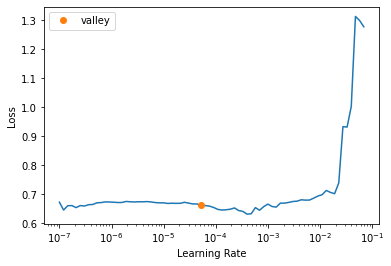

In [ ]:
learn.lr_find()


In [ ]:
learn.fit_one_cycle(1, lr_max=1e-3)


epoch,train_loss,valid_loss,time
0,0.523373,0.480889,00:13


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, lr_max=slice(1e-8, 1e-6))

epoch,train_loss,valid_loss,time
0,0.528208,0.481631,00:27
1,0.491082,0.481725,00:27


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)


,text,target,prediction
0,"Spansion products are to be available from both AMD and Fujitsu, AMD said. Spansion Flash memory solutions are available worldwide from AMD and Fujitsu.",equivalent,equivalent
1,"However, EPA officials would not confirm the 20 percent figure. Only in the past few weeks have officials settled on the 20 percent figure.",not_equivalent,not_equivalent


## Tests

The tests below to ensure the core training code above works for **all** pretrained sequence classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

In [ ]:
# hide
try:
    del learn
    del inf_learn
    torch.cuda.empty_cache()
except:
    pass



In [ ]:
# hide
[model_type for model_type in BLURR.get_models(task="SequenceClassification") if (not model_type.startswith("TF"))]



['AlbertForSequenceClassification',
 'BartForSequenceClassification',
 'BertForSequenceClassification',
 'BigBirdForSequenceClassification',
 'BigBirdPegasusForSequenceClassification',
 'CTRLForSequenceClassification',
 'CamembertForSequenceClassification',
 'CanineForSequenceClassification',
 'ConvBertForSequenceClassification',
 'DebertaForSequenceClassification',
 'DebertaV2ForSequenceClassification',
 'DistilBertForSequenceClassification',
 'ElectraForSequenceClassification',
 'FNetForSequenceClassification',
 'FlaubertForSequenceClassification',
 'FunnelForSequenceClassification',
 'GPT2ForSequenceClassification',
 'GPTJForSequenceClassification',
 'GPTNeoForSequenceClassification',
 'HubertForSequenceClassification',
 'IBertForSequenceClassification',
 'LEDForSequenceClassification',
 'LayoutLMForSequenceClassification',
 'LayoutLMv2ForSequenceClassification',
 'LongformerForSequenceClassification',
 'MBartForSequenceClassification',
 'MPNetForSequenceClassification',
 'MegatronB

In [ ]:
# hide
pretrained_model_names = [
    "hf-internal-testing/tiny-albert",
    "hf-internal-testing/tiny-random-bart",
    "hf-internal-testing/tiny-bert",
    "hf-internal-testing/tiny-random-big_bird",
    "hf-internal-testing/tiny-random-bigbird_pegasus",
    "hf-internal-testing/tiny-random-ctrl",
    "camembert-base",
    "hf-internal-testing/tiny-random-canine",
    "YituTech/conv-bert-base",
    "hf-internal-testing/tiny-deberta",
    "hf-internal-testing/tiny-random-deberta-v2",
    "hf-internal-testing/tiny-random-distilbert",
    "hf-internal-testing/tiny-electra",
    "google/fnet-base",
    "hf-internal-testing/tiny-random-flaubert",
    "hf-internal-testing/tiny-random-funnel",
    "hf-internal-testing/tiny-random-gpt2",
    "hf-internal-testing/tiny-random-gptj",
    "hf-internal-testing/tiny-random-gpt_neo",
    "hf-internal-testing/tiny-random-hubert",
    "kssteven/ibert-roberta-base",
    "hf-internal-testing/tiny-random-led",
    "hf-internal-testing/tiny-layoutlm",
    "microsoft/layoutlmv2-base-uncased",
    "hf-internal-testing/tiny-random-longformer",
    "hf-internal-testing/tiny-random-mbart", 
    "hf-internal-testing/tiny-random-mpnet",
    "anton-l/megatron-11b",                            
    "hf-internal-testing/tiny-random-mobilebert",
    "openai-gpt",
    "hf-internal-testing/tiny-random-reformer",
    "google/rembert",
    "hf-internal-testing/tiny-random-roformer",
    'google/reformer-enwik8',    
    "hf-internal-testing/tiny-random-roberta",
    "hf-internal-testing/tiny-random-squeezebert",
    "hf-internal-testing/tiny-random-transfo-xl",
    "hf-internal-testing/tiny-random-xlm",
    "hf-internal-testing/tiny-xlm-roberta",
    "hf-internal-testing/tiny-random-xlnet",
]


In [ ]:
# hide
raw_datasets = load_dataset("imdb", split=['train', 'test'])
raw_datasets[0] = raw_datasets[0].add_column('is_valid', [False] * len(raw_datasets[0]))
raw_datasets[1] = raw_datasets[1].add_column('is_valid', [True] * len(raw_datasets[1]))

final_ds = concatenate_datasets([raw_datasets[0].shuffle().select(range(1000)), raw_datasets[1].shuffle().select(range(200))])
imdb_df = pd.DataFrame(final_ds)


Reusing dataset imdb (/home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/4ea52f2e58a08dbc12c2bd52d0d92b30b88c00230b4522801b3636782f625c5b)


In [ ]:
# hide
from transformers import RobertaTokenizer

model_cls = AutoModelForSequenceClassification
bsz = 2
seq_sz = 32

test_results = []
for model_name in pretrained_model_names:
    error = None

    print(f"=== {model_name} ===\n")

    # 1. get/configure our Hugging Face objects
    tok_class = RobertaTokenizer if ("/ibert" in model_name) else None

    try:
        learn = None
        
        hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(
            model_name, model_cls=model_cls, tokenizer_cls=tok_class, config_kwargs={"num_labels": 2}
        )

        print(f"architecture:\t{hf_arch}\ntokenizer:\t{type(hf_tokenizer).__name__}\nmodel:\t\t{type(hf_model).__name__}\n")

        # not all architectures include a native pad_token (e.g., gpt2, ctrl, etc...), so we add one here
        if hf_tokenizer.pad_token is None:
            hf_tokenizer.add_special_tokens({"pad_token": "<pad>"})
            hf_config.pad_token_id = hf_tokenizer.get_vocab()["<pad>"]
            hf_model.resize_token_embeddings(len(hf_tokenizer))

        # 2. get our DataLoaders
        blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model, max_length=seq_sz, padding="max_length"), CategoryBlock)

        dblock = DataBlock(blocks=blocks, get_x=ColReader("text"), get_y=ColReader("label"), splitter=ColSplitter(col="is_valid"))

        dls = dblock.dataloaders(imdb_df, bs=bsz)

        # 3. configure our Learner
        model = HF_BaseModelWrapper(hf_model)
        learn = Learner(
            dls,
            model,
            opt_func=partial(Adam),
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy],
            cbs=[HF_BaseModelCallback],
            splitter=hf_splitter,
        )

        learn.freeze()

        b = dls.one_batch()

        # 4. train
        print("*** TESTING DataLoaders ***")
        test_eq(len(b), bsz)
        test_eq(len(b[0]["input_ids"]), bsz)
        test_eq(b[0]["input_ids"].shape, torch.Size([bsz, seq_sz]))
        test_eq(len(b[1]), bsz)

        #         print('*** TESTING One pass through the model ***')
        #         preds = learn.model(b[0])
        #         test_eq(len(preds[0]), bsz)
        #         test_eq(preds[0].shape, torch.Size([bsz, 2]))

        print("*** TESTING Training/Results ***")
        learn.fit_one_cycle(1, lr_max=1e-3, cbs=ShortEpochCallback(pct=0.2, short_valid=True))

        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, "PASSED", ""))
        learn.show_results(learner=learn, max_n=2, trunc_at=250)
    except Exception as err:
        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, "FAILED", err))
    finally:
        # cleanup
        if learn:
            del learn
        torch.cuda.empty_cache()



=== hf-internal-testing/tiny-albert ===

architecture:	albert
tokenizer:	AlbertTokenizerFast
model:		AlbertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,i have to say i was pleasantly surprised by this movie. other than the mother being a complete moron on a few oc,1,1
1,i was on my way out one morning when i was checking something on the t.v. and came across this film. i don',1,1


=== hf-internal-testing/tiny-random-bart ===

architecture:	bart
tokenizer:	BartTokenizerFast
model:		BartForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"This is a wonderful movie, and I still love it! It just so magical and it is f",1,1
1,"At first I didn't think I would like this movie, but as it progressed it became better and",1,0


=== hf-internal-testing/tiny-bert ===

architecture:	bert
tokenizer:	BertTokenizerFast
model:		BertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,this is absolutely beyond question the worst movie i have ever seen. it is so bad in fact that i plan on renting it again as soon as,0,1
1,"i know it's hard for you americans to find european films on video / dvd, particularly from the 80's but please seek out the original",0,1


=== hf-internal-testing/tiny-random-big_bird ===

=== hf-internal-testing/tiny-random-bigbird_pegasus ===

architecture:	bigbird_pegasus
tokenizer:	PegasusTokenizerFast
model:		BigBirdPegasusForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,The bad news: the Canadian version,0,1
1,A young woman leaves her provin,1,1


=== hf-internal-testing/tiny-random-ctrl ===



/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/transformers/models/ctrl/modeling_ctrl.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  angle_rates = 1 / torch.pow(10000, (2 * (i // 2)) / d_model_size)
Using pad_token, but it is not set yet.


architecture:	ctrl
tokenizer:	CTRLTokenizer
model:		CTRLForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"I know it's hard for you Americans to find European films on video/DVD, particularly from the 80's but please seek out the original version of the Vanishing - title S@@",0,0
1,"I rented this movie without having heard (or read) anything about it. What a shame! This movie is intelligent, witty, hilarious, fast-paced, and realistically ridiculous. The characters manage",1,0


=== camembert-base ===

architecture:	camembert
tokenizer:	CamembertTokenizerFast
model:		CamembertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"This is the funniest movie I have ever seen. However, I have laughed harder at plenty of movie",1,1
1,"This movie is simply excellent. For some reason it wasn't a success at the box office in India. In New York,",1,1


=== hf-internal-testing/tiny-random-canine ===



Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.


architecture:	canine
tokenizer:	CanineTokenizer
model:		CanineForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,Obviously the previous reviewe,1,0
1,My Father The Hero used to be,1,0


=== YituTech/conv-bert-base ===

architecture:	convbert
tokenizer:	ConvBertTokenizerFast
model:		ConvBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"nickelodeon has gone down the toilet. they have kids saying things like "" oh my god! "" and "" we're screwed "" < br / >",0,0
1,this film is bone chilling in a way that is hard to describe. while it is fairly accurate in its description of the events leading up to and the,1,0


=== hf-internal-testing/tiny-deberta ===

architecture:	deberta
tokenizer:	DebertaTokenizerFast
model:		DebertaForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time


=== hf-internal-testing/tiny-random-deberta-v2 ===

architecture:	deberta_v2
tokenizer:	DebertaV2Tokenizer
model:		DebertaV2ForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"If this is the author's and director's idea of a slice of life, they are clinically manic depressives. A sad, moody film",0,0
1,"At the heart of almost every truly great crime thriller is a carefully considered, methodically planned-out high stakes super-crime, which 9 times out of",0,0


=== hf-internal-testing/tiny-random-distilbert ===

architecture:	distilbert
tokenizer:	DistilBertTokenizerFast
model:		DistilBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,10 / 10 < br / > < br / > plot discussion <,1,1
1,the movie jennifer with ida lupino a,1,1


=== hf-internal-testing/tiny-electra ===

architecture:	electra
tokenizer:	ElectraTokenizerFast
model:		ElectraForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,take someone you love or want to love and go see this film. < br / > < br / > it touches you in all,1,0
1,"this is one of those films with a great potential. brilliant actors, a debut from a very interesting director and a h",0,0


=== google/fnet-base ===

architecture:	fnet
tokenizer:	FNetTokenizerFast
model:		FNetForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time


=== hf-internal-testing/tiny-random-flaubert ===

architecture:	flaubert
tokenizer:	FlaubertTokenizer
model:		FlaubertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Meticulously constructed and perfectly played, To The Ends Of The Earth is a simply astonishing voyage",1,1
1,"This is a Very Very Boring and uninteresting action film, and without Chuck Norris it would have been unbear",0,1


=== hf-internal-testing/tiny-random-funnel ===

architecture:	funnel
tokenizer:	FunnelTokenizerFast
model:		FunnelForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,as you may remember i have seem all th,0,1
1,"you know, i always fancy disturbing",0,0


=== hf-internal-testing/tiny-random-gpt2 ===



Using pad_token, but it is not set yet.


architecture:	gpt2
tokenizer:	GPT2TokenizerFast
model:		GPT2ForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,Let me break down this film for you...<br /><br />The first fifte,0,0
1,A group of douche-bag teenagers go up to an old mining town in hopes of fin,0,0


=== hf-internal-testing/tiny-random-gptj ===

=== hf-internal-testing/tiny-random-gpt_neo ===



Using pad_token, but it is not set yet.


architecture:	gpt_neo
tokenizer:	GPT2TokenizerFast
model:		GPTNeoForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"The movie opens with Charlie (Jeff Daniels), a business man just finishing",0,1
1,Something I think some people miss about great science fiction is that it predicts some,1,1


=== hf-internal-testing/tiny-random-hubert ===

=== kssteven/ibert-roberta-base ===

architecture:	ibert
tokenizer:	RobertaTokenizer
model:		IBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"According to the article at http://blog.ifeng.com/article/2737487.html, one of the actors in the film,",0,1
1,"This movie was sheer, slow, plodding torture. Not being a fan of slasher films, and preferring classic horror, I may not be",0,1


=== hf-internal-testing/tiny-random-led ===

architecture:	led
tokenizer:	LEDTokenizerFast
model:		LEDForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,During the brief period between Clint Eastwood's string of spaghetti,1,0
1,just saw this film at resfest and was floored. i've never been a huge fan,1,0


=== hf-internal-testing/tiny-layoutlm ===

architecture:	layoutlm
tokenizer:	LayoutLMTokenizerFast
model:		LayoutLMForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"well in to 2002 i've got some catching up to do. and looking back on a lacklustre year, best in show",1,1
1,"rented this one by mistake thinking it was another film with the same title, and realizing that i had rent",0,1


=== microsoft/layoutlmv2-base-uncased ===

architecture:	layoutlmv2
tokenizer:	LayoutLMv2TokenizerFast
model:		LayoutLMv2ForSequenceClassification

Could not do one pass in your dataloader, there is something wrong in it
=== hf-internal-testing/tiny-random-longformer ===

architecture:	longformer
tokenizer:	LongformerTokenizerFast
model:		LongformerForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,Very nice movie! I was browsing the channels on my TV and I usually ignore,1,1
1,During the brief period between Clint Eastwood's string of spaghetti,1,1


=== hf-internal-testing/tiny-random-mbart ===

architecture:	mbart
tokenizer:	MBartTokenizerFast
model:		MBartForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,SO THIS IS where Columbia's he,0,0
1,Palwol ui Christmas is very Kor,1,0


=== hf-internal-testing/tiny-random-mpnet ===

architecture:	mpnet
tokenizer:	MPNetTokenizerFast
model:		MPNetForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,now i've seen it all. just when i thou,0,1
1,"you know, i always fancy disturbing",0,1


=== anton-l/megatron-11b ===

=== hf-internal-testing/tiny-random-mobilebert ===

architecture:	mobilebert
tokenizer:	MobileBertTokenizerFast
model:		MobileBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,one night at mccool's / ( 2001 ) * * * ( o,1,1
1,if you have ever seen a bollywood mov,1,1


=== openai-gpt ===



Using pad_token, but it is not set yet.


architecture:	openai
tokenizer:	OpenAIGPTTokenizerFast
model:		OpenAIGPTForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"crimson begins with some cool jazzy music so i liked it immediately, but as the film wore on i began to wonder if the music wasn't the best",1,0
1,"to be honest, i did never read one of the comics and cannot remember part 2 and 3 at all. i can compare to the first part ( wer",0,1


=== hf-internal-testing/tiny-random-reformer ===



Using pad_token, but it is not set yet.


architecture:	reformer
tokenizer:	ReformerTokenizerFast
model:		ReformerForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time


=== google/rembert ===

architecture:	rembert
tokenizer:	RemBertTokenizerFast
model:		RemBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Not even original in the plot. Ho hum. There were a couple of angles that could have been quite interesting, but the film follows the path of",0,1
1,"Anytime I'm not giving 150% to my dreams or my goals I think of Mark Borchardt, the real-life subject of """,1,1


=== hf-internal-testing/tiny-random-roformer ===

architecture:	roformer
tokenizer:	RoFormerTokenizerFast
model:		RoFormerForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,a better film could have been made to portray the tragedy of bosnia. some parts are very ef,0,1
1,this movie is very silly and very funny. you can't ever criticize it for taking itself serio,1,1


=== google/reformer-enwik8 ===

=== hf-internal-testing/tiny-random-roberta ===

architecture:	roberta
tokenizer:	RobertaTokenizerFast
model:		RobertaForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Dear Readers,<br /><br />I've found in my studies of movies that when",0,1
1,SO THIS IS where Columbia's head of their Short Subjects Unit got,0,1


=== hf-internal-testing/tiny-random-squeezebert ===

architecture:	squeezebert
tokenizer:	SqueezeBertTokenizerFast
model:		SqueezeBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,the movie jennifer with ida lupino a,1,0
1,my father the hero used to be my favor,1,0


=== hf-internal-testing/tiny-random-transfo-xl ===



Using pad_token, but it is not set yet.


architecture:	transfo_xl
tokenizer:	TransfoXLTokenizer
model:		TransfoXLForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,This film is bone chilling in a way that is hard to describe. While it is fairly accurate in its description of the events leading up to and the subsequent investigation,1,1
1,Please -- if you haven't attempted to sit through this garbage and are considering viewing this flick / mini-series -- do yourself a favor and find anything else to,0,1


=== hf-internal-testing/tiny-random-xlm ===

architecture:	xlm
tokenizer:	XLMTokenizer
model:		XLMForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"if you have ever seen a bollywood movie, you know they are longer than most movies due to the multiple song and dance routines ( each one is",1,0
1,looking for proof that real life is more entertaining than fiction? you just found it. this superb documentary about an aspiring feature filmmaker ( mark bortchart,1,0


=== hf-internal-testing/tiny-xlm-roberta ===

architecture:	xlm_roberta
tokenizer:	XLMRobertaTokenizerFast
model:		XLMRobertaForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"I decided to watch this on FearNet on demand for free because I figured well, no",1,1
1,"This movie is George C. Scott at his very best, Bernard Hughes at his very best",1,1


=== hf-internal-testing/tiny-random-xlnet ===

architecture:	xlnet
tokenizer:	XLNetTokenizerFast
model:		XLNetForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Dear Readers,<br /><br />I've found",0,1
1,Not even original in the plot. Ho hum. There were,0,1


In [ ]:
# hide_input
test_results_df = pd.DataFrame(test_results, columns=["arch", "tokenizer", "model", "result", "error"])
display_df(test_results_df)


,arch,tokenizer,model,result,error
0,albert,AlbertTokenizerFast,AlbertForSequenceClassification,PASSED,
1,bart,BartTokenizerFast,BartForSequenceClassification,PASSED,
2,bert,BertTokenizerFast,BertForSequenceClassification,PASSED,
3,bert,BertTokenizerFast,BertForSequenceClassification,FAILED,"Error(s) in loading state_dict for BigBirdForSequenceClassification:\n\tsize mismatch for classifier.out_proj.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([2, 32]).\n\tsize mismatch for classifier.out_proj.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([2])."
4,bigbird_pegasus,PegasusTokenizerFast,BigBirdPegasusForSequenceClassification,PASSED,
5,ctrl,CTRLTokenizer,CTRLForSequenceClassification,PASSED,
6,camembert,CamembertTokenizerFast,CamembertForSequenceClassification,PASSED,
7,canine,CanineTokenizer,CanineForSequenceClassification,PASSED,
8,convbert,ConvBertTokenizerFast,ConvBertForSequenceClassification,PASSED,
9,deberta,DebertaTokenizerFast,DebertaForSequenceClassification,FAILED,mat1 and mat2 shapes cannot be multiplied (2x32 and 768x768)


## Summary

This module includes the fundamental building blocks for training using Blurr

In [ ]:
# hide
from nbdev.export import notebook2script

notebook2script()


Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01_modeling-core.ipynb.
Converted 02_data-language-modeling.ipynb.
Converted 02_modeling-language-modeling.ipynb.
Converted 03_data-token-classification.ipynb.
Converted 03_modeling-token-classification.ipynb.
Converted 04_data-question-answering.ipynb.
Converted 04_modeling-question-answering.ipynb.
Converted 10_data-seq2seq-core.ipynb.
Converted 10_modeling-seq2seq-core.ipynb.
Converted 11_data-seq2seq-summarization.ipynb.
Converted 11_modeling-seq2seq-summarization.ipynb.
Converted 12_data-seq2seq-translation.ipynb.
Converted 12_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-high-level-api.ipynb.
Converted 99b_examples-glue.ipynb.
Converted 99c_examples-glue-plain-pytorch.ipynb.
Converted 99d_examples-multilabel.ipynb.
Converted 99e_examples-causal-lm-gpt2.ipynb.
Converted index.ipynb.
